In [1]:
#As we dont have any GPU we will be using google collab for GPU usage
#Mout at drive 
import sys
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#useful downloads
!pip install bnlp_toolkit
!pip install chart-studio


     |████████████████████████████████| 23.9 MB 98 kB/s 
     |████████████████████████████████| 1.2 MB 35.2 MB/s 
     |████████████████████████████████| 743 kB 35.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 64 kB 2.6 MB/s 


In [20]:
#import packages

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
import re
import sys
import warnings
import pandas as pd
import numpy as np
from sklearn import preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
#import plotly.plotly as py
import plotly.offline as pyo
pyo.init_notebook_mode()
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from bnlp.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

Output hidden; open in https://colab.research.google.com to view.

In [21]:
#read the data
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/bangla_comments_tokenized.csv')
df.tail()


,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
42031,religious,নাস্তিকএ কঠিন শায়েস্ কর দরক,নাস্তিকএদের কঠিন শায়েস্ করা দরকার,"['নাস্তিকএদের', 'কঠিন', 'শায়েস্', 'করা', 'দরকার']","['নাস্তিকএ', 'কঠিন', 'শায়েস্', 'কর', 'দরক']",5
42032,sexual,আয় না রে আয় না রে এক চোদা খা না রে,আয় না রে আয় না রে একটা চোদা খা না রে,"['আয়', 'না', 'রে', 'আয়', 'না', 'রে', 'একটা', '...","['আয়', 'না', 'রে', 'আয়', 'না', 'রে', 'এক', 'চো...",11
42033,religious,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,"['কথা', 'সত্য', 'ভাই', 'হিন্', 'ধর্ম', 'বিশ্বা...","['কথা', 'সত্য', 'ভাই', 'হিন্', 'ধর্ম', 'বিশ্বা...",8
42034,religious,সালা মালাউন বাচ্চা তর্ক না লতা পা দিয়ে ঘের দিয়...,সালা মালাউনের বাচ্চা তর্ক না লতা পা দিয়ে ঘের দ...,"['সালা', 'মালাউনের', 'বাচ্চা', 'তর্ক', 'না', '...","['সালা', 'মালাউন', 'বাচ্চা', 'তর্ক', 'না', 'লত...",21
42035,religious,কুও কথা কাফ,কুওার কথা কাফের,"['কুওার', 'কথা', 'কাফের']","['কুও', 'কথা', 'কাফ']",3


In [22]:
#rename  'not bully' to 'acceptable'
df['label'] = df['label'].replace({'not bully':'acceptable'})
df.head()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
0,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,"['ছালা', 'পাকিস্তানীদের', 'বাশ', 'দিয়া', 'দাও'...","['ছালা', 'পাকিস্তানী', 'বাশ', 'দিয়া', 'দাও', '...",13
1,religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,"['ফ্যামিলিটাই', 'নাস্তিক', 'থকে', 'আশা', 'করা'...","['ফ্যামিলিটা', 'নাস্তিক', 'থক', 'আশা', 'কর', '...",8
2,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,"['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...","['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...",19
3,religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,"['সাফা', 'কবির', 'কঠিনফ্', 'ছিলাম', 'তো', 'চরম...","['সাফা', 'কবির', 'কঠিনফ্', 'ছিল', 'তো', 'চরমঘৃ...",14
4,acceptable,সুপ সুপ হিরো,সুপার সুপার হিরো,"['সুপার', 'সুপার', 'হিরো']","['সুপ', 'সুপ', 'হিরো']",3


In [24]:
#fill na values with zero
df = df.fillna(0)
df.head()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
0,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,"['ছালা', 'পাকিস্তানীদের', 'বাশ', 'দিয়া', 'দাও'...","['ছালা', 'পাকিস্তানী', 'বাশ', 'দিয়া', 'দাও', '...",13
1,religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,"['ফ্যামিলিটাই', 'নাস্তিক', 'থকে', 'আশা', 'করা'...","['ফ্যামিলিটা', 'নাস্তিক', 'থক', 'আশা', 'কর', '...",8
2,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,"['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...","['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...",19
3,religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,"['সাফা', 'কবির', 'কঠিনফ্', 'ছিলাম', 'তো', 'চরম...","['সাফা', 'কবির', 'কঠিনফ্', 'ছিল', 'তো', 'চরমঘৃ...",14
4,acceptable,সুপ সুপ হিরো,সুপার সুপার হিরো,"['সুপার', 'সুপার', 'হিরো']","['সুপ', 'সুপ', 'হিরো']",3


In [25]:
# label encoding for output

sample_data = [2000,5000,10000,20000,30000,40000]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

df.labels = label_encoding(df.label,True)


			 Label Encoding  
Class Names: ['Political' 'acceptable' 'religious' 'sexual']
acceptable   1 

acceptable   1 

religious   2 

Political   0 

acceptable   1 

religious   2 



In [26]:
#confusion matrix

def conf_matrix(pred,classfier,directory,filename):
  predictions = pred
  y_pred = np.array(predictions)
  cm = confusion_matrix(y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['Political', 'acceptable', 'religious', 'sexual'], 
                       columns = ['Political', 'acceptable', 'religious', 'sexual'])
  plt.figure(figsize=(8,6))
  sn.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.title('\n'+classfier+'Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  plt.show()
  plt.close()

In [27]:
#report generation

def report_generate(pred,classfier,directory,filename):
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred = pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'political','1':'acceptable','2':'religious','3':'sexual'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  
  plot=plt.tick_params(rotation=40)
  plt.figure.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  
  return plot,report

In [28]:
#plot comaparison 
def compare_plots(y_value,directory,filename):
  plt.subplots(figsize=(11,8))
  sn.barplot(x="Name", y=y_value ,data=compare,palette='hot',edgecolor=sn.color_palette('dark',7))
  plt.xticks(rotation=45)
  plt.title('Comparing techniques with '+y_value+'.')
  plt.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  plt.show()
  return plt

In [29]:
#divide the model for trainning and testing
df.text=df.text.apply(str)
X = df.text.values
y = df.labels
#categories = ['label_sexual','label_religious','label_troll','label_threat','label_acceptable']  #targeted labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(33628,)
(8408,)
(33628,)
(8408,)


**MultinomialNB model with Tfidf using pipeline**

In [31]:
# Define a pipeline combining a text feature extractor with multi lable classifier
TFIDF_NB_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000, min_df=5,ngram_range=(1,2))),
                
                ('clf', OneVsRestClassifier(MultinomialNB(
                    alpha=0.15,fit_prior=True, class_prior=None))),
            ])

TFIDF_NB_pipeline.fit(X_train, y_train)
TFIDF_NB_pipeline_prediction = TFIDF_NB_pipeline.predict(X_test)

NB = accuracy_score(TFIDF_NB_pipeline_prediction, y_test)
#NB_f1 = f1_score(TFIDF_NB_pipeline_prediction, y_test)
print('accuracy %s' % accuracy_score(TFIDF_NB_pipeline_prediction, y_test))

accuracy 0.8076831588962893


,precision,recall,f1-score
political,78.75,89.89,83.95
acceptable,81.27,73.34,77.10
religious,83.16,83.98,83.57
sexual,80.68,75.90,78.22
accuracy,80.77,80.77,80.77
macro avg,80.97,80.78,80.71
weighted avg,80.85,80.77,80.64


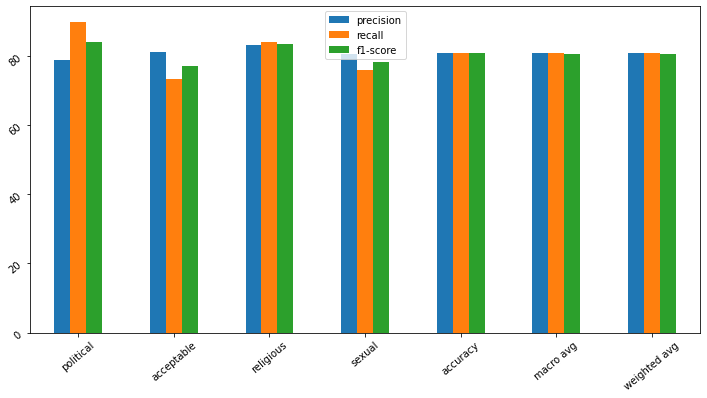

In [ ]:
sNB_report=report_generate(TFIDF_NB_pipeline_prediction,"NaiveBayes","MultiNB","multiNB_report")
NB_report[1]

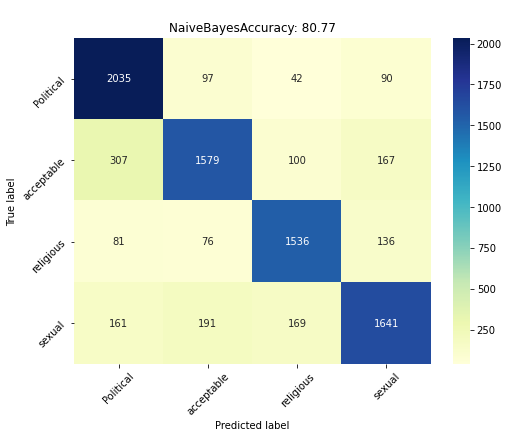

In [ ]:
conf_matrix(TFIDF_NB_pipeline_prediction,"NaiveBayes","MultiNB","multinb_confusion")

**SGDclassifier model with TFIDF using pipeline**

In [ ]:

TFIDF_SGD_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=90, tol=None)))
            ])


TFIDF_SGD_pipeline.fit(X_train, y_train)
TFIDF_SGD_pipeline_prediction = TFIDF_SGD_pipeline.predict(X_test)
SGD = accuracy_score(TFIDF_SGD_pipeline_prediction, y_test)
#SGD_f1 = f1_score(TFIDF_SGD_pipeline_prediction, y_test)

print('accuracy %s' % accuracy_score(TFIDF_SGD_pipeline_prediction, y_test))


accuracy 0.8365842055185537


,precision,recall,f1-score
political,81.57,88.16,84.74
acceptable,77.53,81.56,79.49
religious,94.97,84.69,89.54
sexual,83.92,80.16,82.00
accuracy,83.66,83.66,83.66
macro avg,84.50,83.64,83.94
weighted avg,84.06,83.66,83.73


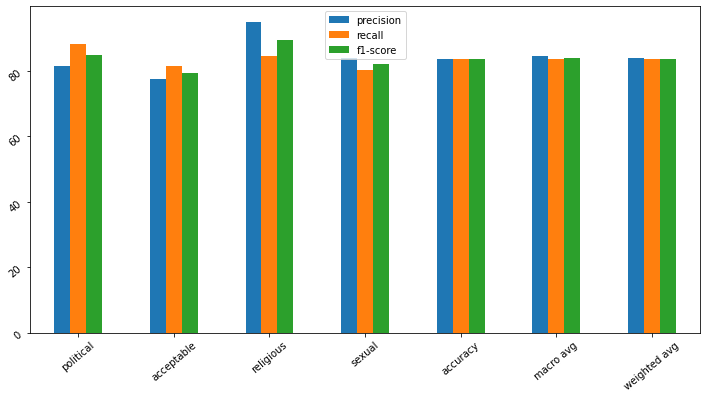

In [ ]:
SGD_report=report_generate(TFIDF_SGD_pipeline_prediction,"SGD classifier","SGD","SGD_report")
SGD_report[1]

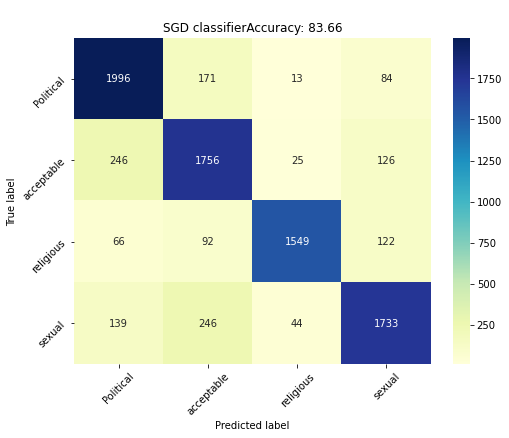

In [ ]:
conf_matrix(TFIDF_SGD_pipeline_prediction,"SGD classifier","SGD","SGD_confusion")

**Logistic Regression model with TFIDF using pipeline**

In [ ]:
TFIDF_LR_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(C=0.7,random_state=42,tol=0.0001,max_iter=200)))
            ])

TFIDF_LR_pipeline.fit(X_train, y_train)
TFIDF_LR_pipeline_prediction = TFIDF_LR_pipeline.predict(X_test)
LR = accuracy_score(TFIDF_LR_pipeline_prediction, y_test)
#LR_f1 = f1_score(TFIDF_LR_pipeline_prediction, y_test)

print('accuracy %s' % accuracy_score(TFIDF_LR_pipeline_prediction, y_test))



accuracy 0.8283777354900095


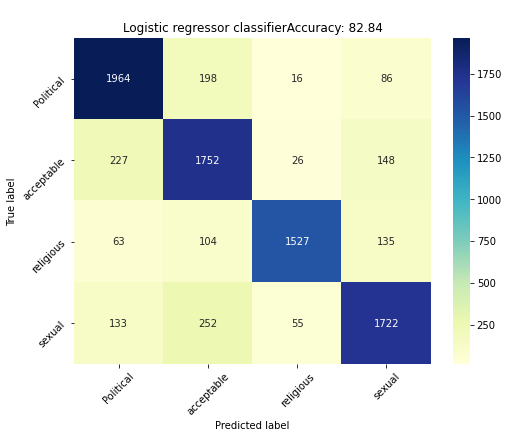

In [ ]:
conf_matrix(TFIDF_LR_pipeline_prediction,"Logistic regressor classifier","Logistic Regression","LR_confusion")

,precision,recall,f1-score
political,82.28,86.75,84.45
acceptable,75.98,81.37,78.58
religious,94.03,83.49,88.44
sexual,82.35,79.65,80.98
accuracy,82.84,82.84,82.84
macro avg,83.66,82.82,83.12
weighted avg,83.24,82.84,82.93


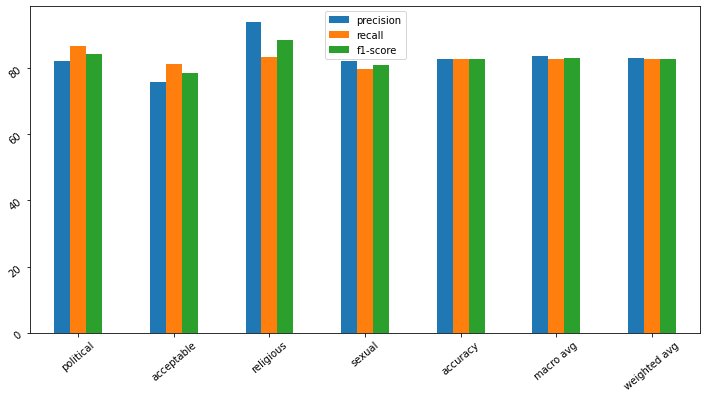

In [ ]:
LR_report=report_generate(TFIDF_LR_pipeline_prediction,"Logistic regressor classifier","Logistic Regression","LR_report")
LR_report[1]

**RandomforrestClassifier model with TFIDF using pipeline**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
TFIDF_DT_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=200,criterion ='entropy')))
            ])


TFIDF_DT_pipeline.fit(X_train, y_train)
TFIDF_DT_pipeline_prediction = TFIDF_DT_pipeline.predict(X_test)
DT = accuracy_score(TFIDF_DT_pipeline_prediction, y_test)
#DT_f1 = f1_score(TFIDF_DT_pipeline_prediction, y_test)

print('accuracy %s' % accuracy_score(TFIDF_DT_pipeline_prediction, y_test))



accuracy 0.8449096098953378


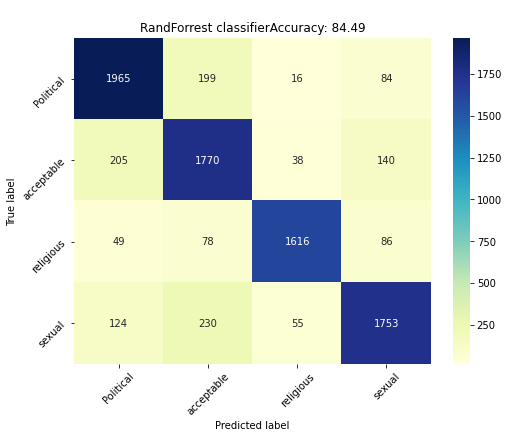

In [ ]:
conf_matrix(TFIDF_DT_pipeline_prediction,"RandForrest classifier","Random forrest","RF_confusion")

,precision,recall,f1-score
political,83.87,86.79,85.30
acceptable,77.73,82.21,79.91
religious,93.68,88.35,90.94
sexual,84.97,81.08,82.98
accuracy,84.49,84.49,84.49
macro avg,85.06,84.61,84.78
weighted avg,84.72,84.49,84.55


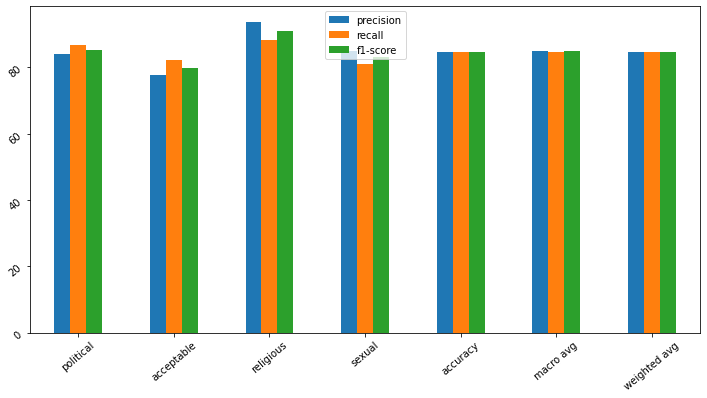

In [ ]:
DT_report=report_generate(TFIDF_DT_pipeline_prediction,"RandForrest classifier","Random forrest","RF_report")
DT_report[1]

**SVC**

In [ ]:

TFIDF_SVC_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SVC(random_state=42)))
            ])


TFIDF_SVC_pipeline.fit(X_train, y_train)
TFIDF_SVC_pipeline_prediction = TFIDF_SVC_pipeline.predict(X_test)
SVC = accuracy_score(TFIDF_SVC_pipeline_prediction, y_test)
 #SVC_f1 = f1_score(TFIDF_SVC_pipeline_prediction, y_test)
print('accuracy %s' % accuracy_score(TFIDF_SVC_pipeline_prediction, y_test))


accuracy 0.8510941960038059


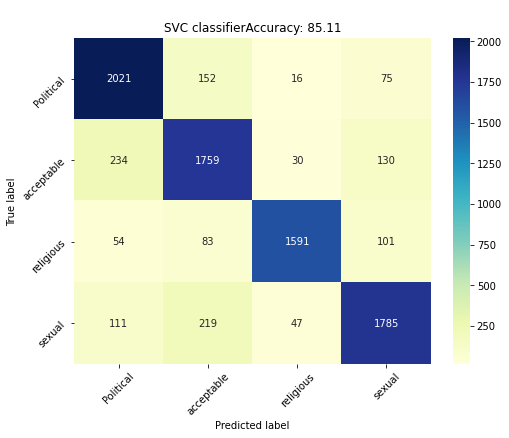

In [ ]:
conf_matrix(TFIDF_SVC_pipeline_prediction,"SVC classifier","SVC","SVC_confusion")

,precision,recall,f1-score
political,83.51,89.27,86.29
acceptable,79.48,81.70,80.58
religious,94.48,86.99,90.58
sexual,85.37,82.56,83.94
accuracy,85.11,85.11,85.11
macro avg,85.71,85.13,85.35
weighted avg,85.34,85.11,85.16


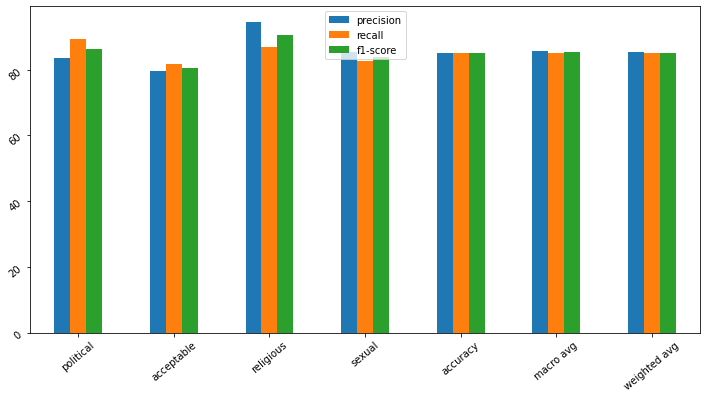

In [ ]:
SVC_report=report_generate(TFIDF_SVC_pipeline_prediction,"SVC classifier","SVC","SVC_report")
SVC_report[1]

**Result Comparison**

In [ ]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives

def true_positive(y_true, y_pred):   
    tp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):
    tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1
    return fp

def false_negative(y_true, y_pred):
    fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1

In [ ]:
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize precision to 0
    precision = 0
    categories = 4
    # loop over all classes
    for class_ in range (categories):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    return precision

In [ ]:

MLA = {
     'Naive Bayes' : TFIDF_NB_pipeline,
     'SGD Classifier' : TFIDF_SGD_pipeline,
     'Logistic Regression' : TFIDF_LR_pipeline,
     'Random Forrest' : TFIDF_DT_pipeline,
     'SVC' : TFIDF_SVC_pipeline  
}

In [ ]:
columns = []
compare = pd.DataFrame(columns = columns)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=4
row_index = 0
for name,alg in MLA.items():
    #fp, tp, th = roc_curve(y_test, predicted ,pos_label=['Political', 'acceptable', 'religious', 'sexual'])
    MLA_name = name
    #alg.fit(X_train, y_train)
    predicted = alg.predict(X_test)
    micro_averaged_recall = recall_score(y_test, predicted, average = 'micro')
    macro_averaged_f1 = f1_score(y_test, predicted, average = 'macro')
    
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    compare.loc[row_index, 'Precision'] = macro_precision(y_test, predicted)
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = macro_averaged_f1
    row_index+=1
    
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare

,Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
4,SVC,0.9690,0.8511,0.857101,0.851094,0.853474
3,Random Forrest,0.9900,0.8449,0.850638,0.844910,0.847842
1,SGD Classifier,0.8752,0.8366,0.844979,0.836584,0.839413
2,Logistic Regression,0.8672,0.8284,0.836587,0.828378,0.831151
0,Naive Bayes,0.8352,0.8077,0.809651,0.807683,0.807096


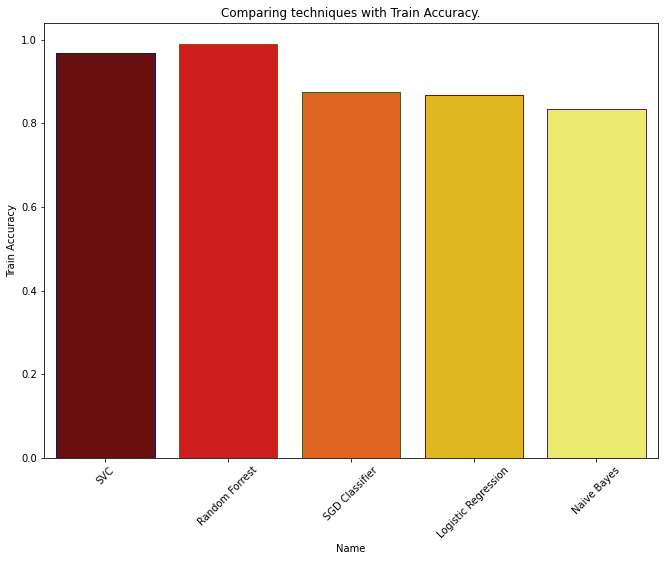

In [ ]:
train_comparison=compare_plots("Train Accuracy","ML comparison","train comparison")

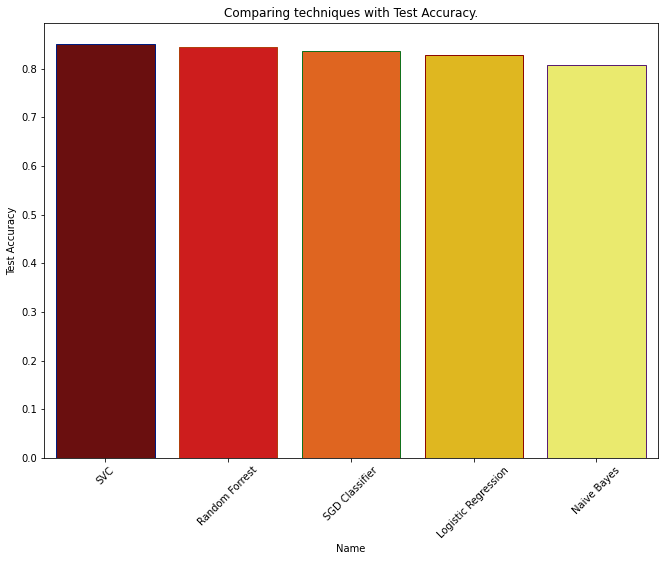

In [ ]:
test_comparison=compare_plots("Test Accuracy","ML comparison","test comparison")

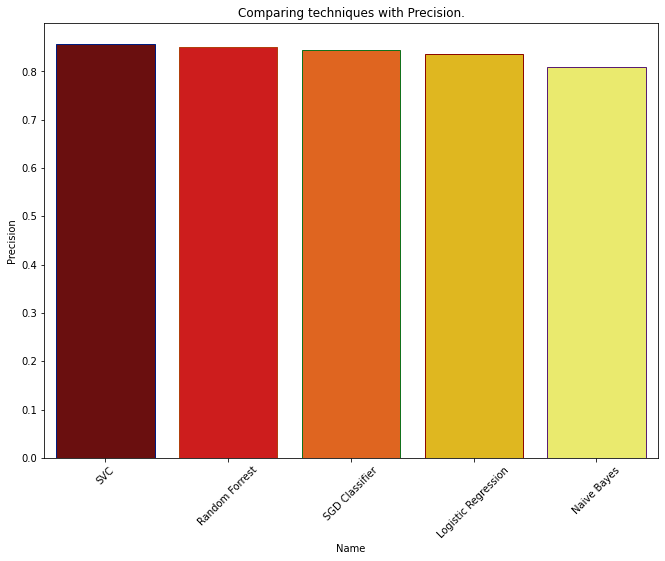

In [ ]:
Precision_comparison=compare_plots("Precision","ML comparison","Precision comparison")

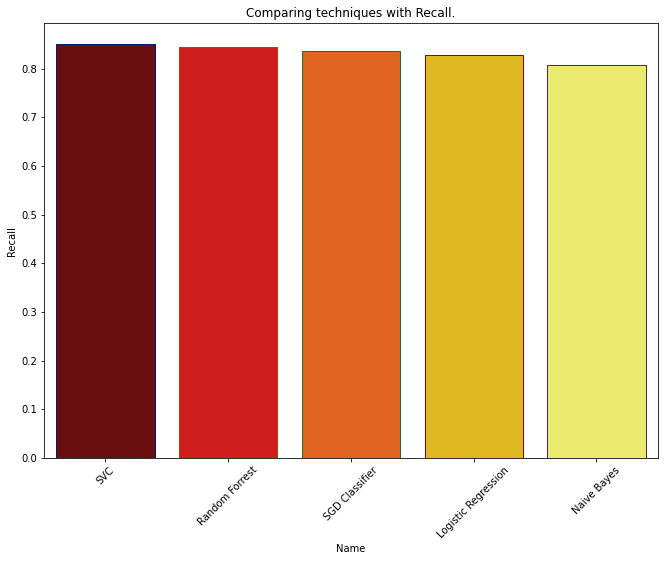

In [ ]:
Recall_comparison=compare_plots("Recall","ML comparison","Recall comparison")

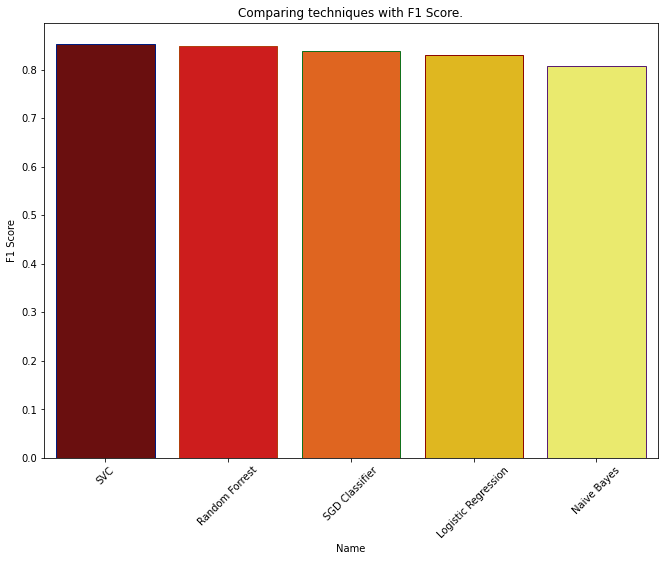

In [ ]:
F1_comparison=compare_plots("F1 Score","ML comparison","F1 Score comparison")

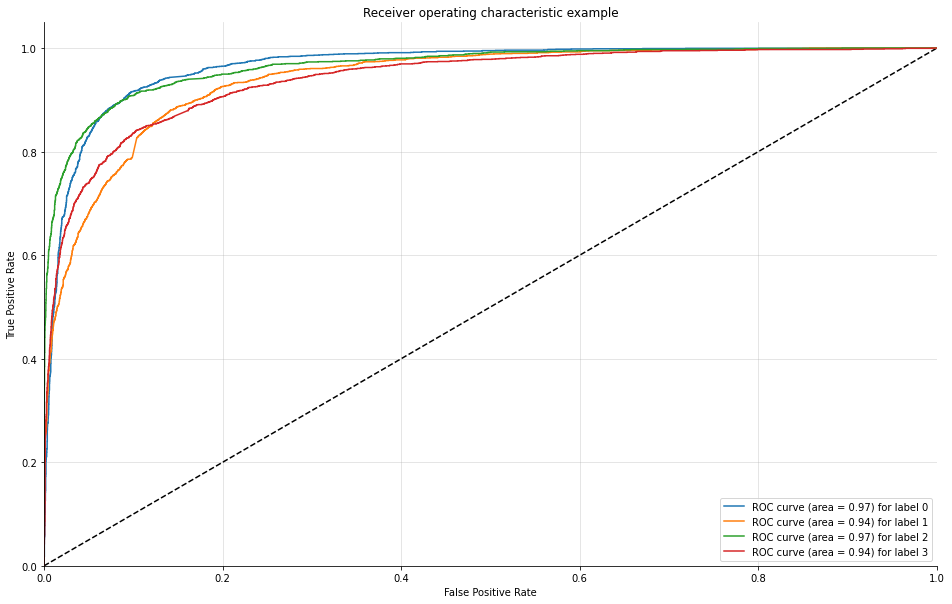

In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

plot_multiclass_roc(TFIDF_NB_pipeline, X_test, y_test, n_classes=4, figsize=(16, 10))